## 1、加载数据

In [1]:
from keras.datasets import boston_housing

(train_data,train_targets),(test_data,test_targets)=boston_housing.load_data()

G:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2、准备数据

In [9]:
# 1、数据标准化
mean=train_data.mean(axis=0)
train_data -= mean
std=train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 3、构建网络

In [3]:
from keras import models
from keras import layers

def build_model():
    model=models.Sequential()  # 因为需要将同一个模型多次案例化，所以用一个函数来构建模型
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

## 4、利用K折线来验证方法

In [4]:
import numpy as np

k=4
num_val_samples=len(train_data)//k
num_epochs=100
all_scores=[]

for i in range(k):
    print('processing fold #',i)
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data=np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets=np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model=build_model()
    
    model.fit(partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=1,verbose=0)
    val_mse,val_mae=model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [5]:
all_scores

[2.085620711345484, 2.190251661999391, 2.9128784543216817, 2.4091450902495053]

In [6]:
np.mean(all_scores)

2.3994739794790156

## 5、保存每折的验证结果

In [7]:
num_epochs=500
all_mae_histories=[]
for i in range(k):
    print('processing fold #',i)
    
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data=np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets=np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model=build_model()
    history=model.fit(partial_train_data,partial_train_targets,
                      validation_data=(val_data,val_targets),
                      epochs=num_epochs,batch_size=1,verbose=0)
    mae_history=history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
# 计算所有伦茨的K折验证分数平均值
average_mae_history=[np.mean([x[i] for x in all_mae_histories])for i in range(num_epochs)]

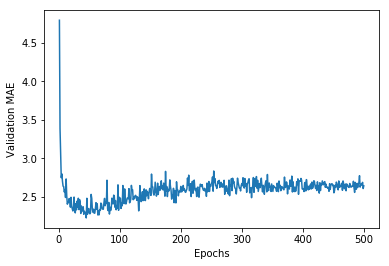

In [10]:
# 绘制验证分数
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

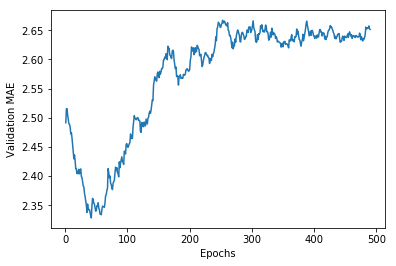

In [13]:
# 绘制验证分数（删除前十个数据点）
def smooth_curve(points,factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
    
smooth_mae_history=smooth_curve(average_mae_history[10:])
    
plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 6、训练最终模型

In [14]:
model=build_model()
model.fit(train_data,train_targets,epochs=80,batch_size=16,verbose=0)
test_mse_score,test_mae_score=model.evaluate(test_data,test_targets)

102/102 [==============================] - 0s 919us/step


In [15]:
test_mae_score

2.670783323400161

# 要点

## 1、回归问题使用的损失函数与分类问题不同。回归问题常用的损失函数是均方误差（MSE）。

## 2、回归问题使用的评估指标也与分类问题不同。常用的回归指标是平均绝对误差（MAE）。

## 3、如果输入数据的特征具有不同的取值范围，应该先进性预处理，对每个特征单独进行缩放。

## 4、如果可用的数据很少，使用K折验证可以可靠地评估模型。

## 5、如果可用的训练数据很少，最好使用隐蔽层较少（通常只有一到两个）的小型网络，以避免验证的过拟合。